# Grid

A tutorial on grid classes, its properties and transformations.

### Content
* [Geometries](#Geometries)
* [Basic properties](#Basic-properties)
* [Grid transformations](#Grid-transformations)
    * [Minimal cube](#Minimal-cube)
    * [Rescale](#Rescale)
    * [Orthogonalization](#Orthogonalization)
    * [Corner-point representation](#Corner-point-representation)
    * [Local grid](#Local-grid)

## Geometries

Proceeding from the finite-difference simulation approach, spatial shape of the reservoir model is discretized into smaller parts called grid blocks (or cells).


### Orthogonal Uniform Grid

Grid describes the reservoir geometry (shape) and defines the blocks with which static and dynamic geological properties are associated.  If all cells are of the same parallelipiped shape and regular size we obtain the uniform orthogonal grid. To specify such a grid one has to set a number of cells in each direction (say, nx, ny and nz) and its sizes (say, dx, dy, dz).
This is the most simple grid type and only 6 numbers are required to completely specify the grid.

In **Deepfield** grids of such type are represented with `OrthofonalUniformGrid` class.

Egg model has grid of such type.

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

from deepfield.field.plot_utils import plot_bounds_3d, plot_bounds_2d
from deepfield import Field, orth_grid_config, corn_grid_config

model = Field('../open_data/egg/Egg_Model_ECL.DATA', config=orth_grid_config).load()

INFO:Field:Start reading ../open_data/egg/RESULTS/Egg_Model_ECL/Egg_Model_ECL.EGRID
INFO:Field:Decoding GRIDHEAD.
INFO:Field:Decoding ACTNUM.
INFO:Field:Finish reading ../open_data/egg/RESULTS/Egg_Model_ECL/Egg_Model_ECL.EGRID
INFO:Field:Start reading Egg_Model_ECL.DATA
INFO:Field:[Egg_Model_ECL.DATA:9] Loading TITLE
INFO:Field:[Egg_Model_ECL.DATA:16] Loading DIMENS
INFO:Field:[Egg_Model_ECL.DATA:19] Loading METRIC
INFO:Field:[Egg_Model_ECL.DATA:20] Loading OIL
INFO:Field:[Egg_Model_ECL.DATA:21] Loading WATER
INFO:Field:[Egg_Model_ECL.DATA:41] Loading START
INFO:Field:[Egg_Model_ECL.DATA:55] Include /home/dvoloskov/code/DeepField/open_data/egg/ACTIVE.INC
INFO:Field:Start reading ACTIVE.INC
INFO:Field:Finish reading ACTIVE.INC
INFO:Field:[Egg_Model_ECL.DATA:58] Loading DX
INFO:Field:[Egg_Model_ECL.DATA:62] Loading DY
INFO:Field:[Egg_Model_ECL.DATA:66] Loading DZ
INFO:Field:[Egg_Model_ECL.DATA:69] Loading TOPS
INFO:Field:[Egg_Model_ECL.DATA:73] Include /home/dvoloskov/code/DeepField/open

In [3]:
type(model.grid)

deepfield.field.grids.OrthogonalUniformGrid

`DIMENS` attribute defines the dimensionality of the grid.

In [4]:
model.grid.dimens

array([60, 60,  7])

Block sizes are contained in `DX`, `DY`, `DZ` attributes.

In [5]:
model.grid.dx, model.grid.dy, model.grid.dz

(8.0, 8.0, 4.0)

`TOPS` define the depth of the upper grid bound.

In [6]:
model.grid.tops

4000.0

### Corner-Point Grid 

One more option of how grid can be defined is Corner-Point geometry. In this case grid is specified by setting up grid pillars and positions of corner points of blocks at this pillars.

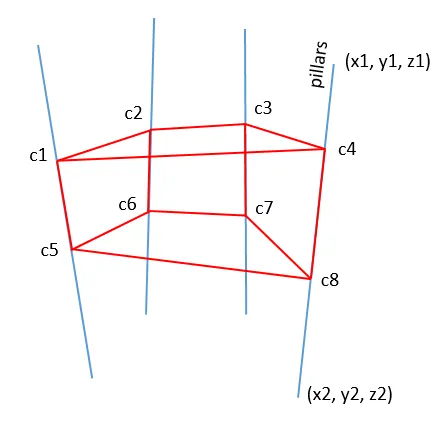

Corner point grid is specified for Norne model. Let

In [7]:
model = Field(path='../open_data/norne_simplified/norne_simplified.data',
              config=corn_grid_config).load()

INFO:Field:Start reading norne_simplified.data
INFO:Field:[norne_simplified.data:3] Loading TITLE
INFO:Field:[norne_simplified.data:9] Loading START
INFO:Field:[norne_simplified.data:13] Loading METRIC
INFO:Field:[norne_simplified.data:14] Loading OIL
INFO:Field:[norne_simplified.data:15] Loading GAS
INFO:Field:[norne_simplified.data:16] Loading WATER
INFO:Field:[norne_simplified.data:17] Loading DISGAS
INFO:Field:[norne_simplified.data:19] Loading DIMENS
INFO:Field:[norne_simplified.data:33] Include /home/dvoloskov/code/DeepField/open_data/norne_simplified/INCLUDE/zcorn.inc
INFO:Field:Start reading zcorn.inc
INFO:Field:[zcorn.inc:1] Loading ZCORN
INFO:Field:Finish reading zcorn.inc
INFO:Field:[norne_simplified.data:37] Include /home/dvoloskov/code/DeepField/open_data/norne_simplified/INCLUDE/coord.inc
INFO:Field:Start reading coord.inc
INFO:Field:[coord.inc:1] Loading COORD
INFO:Field:Finish reading coord.inc
INFO:Field:[norne_simplified.data:41] Include /home/dvoloskov/code/DeepField

`DIMENS` contains model grid dimensionality

In [8]:
model.grid.dimens

array([ 46, 112,  22])

Coordinates of grid pillars are contained in COORD atributes. Each pillar is defined by 6 numbers, coordinates of 2 points ($x_1$, $y_1$, $z_1$) and
($x_2$, $y_2$, $z_2$). Totally $(n_x+1)\times(n_y+1)$ pillars are defined.

In [9]:
model.grid.coord.shape

(47, 113, 6)

$z$ coordinates of blocks are contained in ZCORN keyword. Each block is defined by it`s 8 corners.

In [10]:
model.grid.zcorn.shape

(46, 112, 22, 8)

## Basic properties

List of grid attributes

In [11]:
model.grid.attributes

('MAPAXES', 'DIMENS', 'ZCORN', 'COORD', 'ACTNUM')

Grid dimensions

In [12]:
model.grid.dimens

array([ 46, 112,  22])

Active cells

In [13]:
model.grid.actnum.shape

(46, 112, 22)

Note, that in original model, files arrays are presented in the spatial form.
Method `ravel` transforms all spatial arrays into a ravel shape:

In [14]:
model.grid.ravel()

model.grid.actnum.shape, model.grid.zcorn.shape

((113344,), (906752,))

while `to_spatial` transforms them back into a spatial shape:

In [15]:
model.grid.to_spatial()

model.grid.actnum.shape, model.grid.zcorn.shape

((46, 112, 22), (46, 112, 22, 8))

Grid location with respect to map coordinates and unit vectors in x and y grid directions can be obtained as follows:

In [16]:
model.grid.origin, model.grid.ex, model.grid.ey

(array([   0.    ,    0.    , 3037.4729]), array([1., 0.]), array([0., 1.]))

Attribute `cell_centroinds` gives coordinates of cell centres. Let's get a center of the first cell:

In [17]:
model.grid.cell_centroids[0, 0, 0]

array([4.53215789e+05, 7.32000899e+06, 3.04003159e+03])

Each cell is defined by 8 corners and property `xyz` contains the coordinates. For example, coordinates of the first cell are

In [18]:
model.grid.xyz[0, 0, 0]

array([[4.53114000e+05, 7.31992100e+06, 3.03747290e+03],
       [4.53155031e+05, 7.31984000e+06, 2.98393311e+03],
       [4.53273188e+05, 7.32018000e+06, 3.06804492e+03],
       [4.53321312e+05, 7.32009450e+06, 3.06212988e+03],
       [4.53114000e+05, 7.31992100e+06, 3.03953101e+03],
       [4.53154623e+05, 7.31984080e+06, 2.99024097e+03],
       [4.53273099e+05, 7.32017984e+06, 3.07218799e+03],
       [4.53321063e+05, 7.32009481e+06, 3.06671191e+03]])

Propetry `cell_volumes` provides cell volumes, e.g. for the first cell we have

In [19]:
model.grid.cell_volumes[0, 0, 0]

112955.74164065154

Next we consider grid transformations.

## Grid transformations

### Minimal cube

Quite often active cells occupy only a small region within a grid. It might be useful to crop mininal region that contains active cells. The most simple way is to apply `crop_minimal_active_cube`. It finds minimal slices that contain active cells. The output grid has smaller dimensions:

In [20]:
min_grid, min_slices = model.grid.crop_minimal_cube()
min_grid.dimens, min_slices

(array([36, 92, 22]),
 (slice(5, 41, None), slice(10, 102, None), slice(0, 22, None)))

In [21]:
min_grid.dimens

array([36, 92, 22])

### Rescale

Orthogonal grids can be upscaled and downscaled, for corner point grids only upscaling is well defined. Parameter `factors` specifices scaling factor along each axis. Additional parameter `actnum_upscale` specifies how to transfer active cell into the new grid:

In [22]:
up_grid = model.grid.upscale(factors=(4, 4, 5), actnum_upscale='vote')
print('Original:', model.grid.dimens, 'Upscaled:', up_grid.dimens)

Original: [ 46 112  22] Upscaled: [11 28  4]


Dowscaling is implmented for orthogonal grids only.

### Orthogonalization

Corner point grid can be orthogonalized with respect to the bounding box of the corner point grid:

In [23]:
model.grid.bounding_box

array([[4.53114000e+05, 7.31583550e+06, 2.23026001e+03],
       [4.65658625e+05, 7.33111950e+06, 3.50841309e+03]])

Create a new orthogonal grid:

In [24]:
ort_grid = model.grid.orthogonalize(dimens=(10, 12, 14))
ort_grid.dimens

(10, 12, 14)

Note that grid origin coincides with the bounding box corner:

In [25]:
ort_grid.origin == model.grid.bounding_box[0]

array([ True,  True,  True])

Grid axes coincide with map axes: 

In [26]:
ort_grid.ex, ort_grid.ey

(array([1., 0.]), array([0., 1.]))

### Corner-point representation

Orthoronal grid has a natural corner-point representation:

In [27]:
ort_grid.as_corner_point.attributes

('DIMENS', 'MAPAXES', 'ZCORN', 'COORD', 'ACTNUM')

A new instance can be obtained as

In [28]:
ort_grid.to_corner_point()

### Local grid

Local grid is a corner point grid that is bounded by upper and lower active cell surfaces and splits the space between in a given number of layers. This can be useful to get a grid with reduced number of inactive cells. The only parameter required is a target resolution along z-axis:

In [29]:
grid, grid_mask, z_top, z_bottom = model.grid.crop_minimal_grid(nz=10)
print("Local grid dimens:", grid.dimens)

Local grid dimens: [ 46 112  10]


Next figure shows top and bottom bounds of the local grid

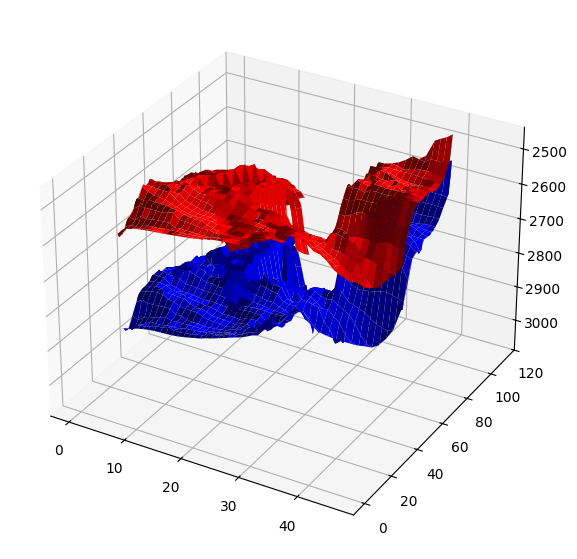

In [30]:
plot_bounds_3d(z_top, z_bottom, figsize=(9, 7))

The same bounds in 2d projections (to active an interactive mode set `x=None` and `y=None`):

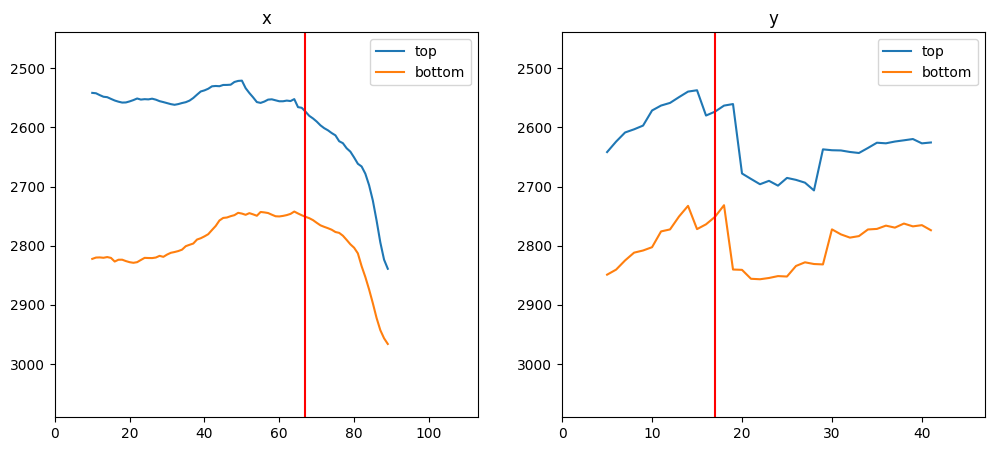

In [31]:
plot_bounds_2d(z_top, z_bottom, x=17, y=67, figsize=(12, 5))

At this point we finish the story about the `Grid` class and invite you to the next tutorials. In this tutorial we discussed various grid transformations. After gridd transformation one usually requires to map static and dynamic spatial parameters of the model to a new grid, this topic is covered in [Properties_transfer](07.Properties_transfer.ipynb) tutorial.